In [ ]:
import torch
import matplotlib.pyplot as plt
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, defaultdict
import nltk
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe

from nltk.corpus import twitter_samples

In [ ]:
nltk.download("twitter_samples")

In [ ]:
nltk.download("stopwords")


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import re
import string

In [ ]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english') 

('Stop words\n')
print(stopwords_english)

print('\nPunctuation\n')
print(string.punctuation)

In [ ]:
def process_tweet(tweet:str):
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)

    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []

    for word in tweet_tokens: # Go through every word in your tokens list
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            tweets_clean.append(word)
    stemmer = PorterStemmer() 

    # Create an empty list to store the stems
    tweets_stem = [] 

    for word in tweets_clean:
        stem_word = stemmer.stem(word)  # stemming word
        tweets_stem.append(stem_word)  # append to the list

    return tweets_stem

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, negative_tweets, positive_tweets,vectors=None,tokenize=lambda x:x.split()):
        self.tweets = []
        if vectors is not None:
            self.vocab = torchtext.vocab.vocab(vectors)
            self.vocab.append_token("<unk>")
            self.vocab.append_token("<pad>")
            self.pad_idx = self.vocab["<pad>"]
            self.unk_idx = self.vocab["<unk>"]
            self.vocab.set_default_index(self.unk_idx)
        else:
            counter = Counter()
        
            for p_tweet in positive_tweets:
                tokens=tokenize(p_tweet)
                counter.update(tokens)
                
            for n_tweet in negative_tweets:
                tokens= tokenize(n_tweet)
                counter.update(tokens)
            self.vocab = torchtext.vocab.vocab(counter)
        

        for p_tweet in positive_tweets:
            tokens=tokenize(p_tweet)
            self.tweets.append((1,self.vocab.forward(tokens)))
        for n_tweet in negative_tweets:
            tokens= tokenize(n_tweet)
            self.tweets.append((0,self.vocab.forward(tokens)))
       
       
    def __getitem__(self, idx):
        return self.tweets[idx]
    def __len__(self):
        return len(self.tweets)
        

In [ ]:
positive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")
glove_vectors = GloVe()
tweet_dataset = TweetDataset(positive_tweets,negative_tweets,glove_vectors.stoi,tokenize=process_tweet)


def collate_batch(batch):
    # batch in that case is List of batches that contain the elements of the iterator
    text_list = []
    target_list=[]
    for (label,x) in batch:
        text_list.append(torch.tensor(x, dtype=torch.int64))
        target_list.append(label)
    
    target_list = torch.tensor(target_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True,padding_value=tweet_dataset.pad_idx)
    return text_list,target_list
    
n = len(tweet_dataset)
split = 0.8
n_train = int(split*n)

n_test = n-n_train

train_loader = DataLoader(tweet_dataset[0:n_train], batch_size=64, collate_fn=collate_batch,shuffle=True)
test_loader = DataLoader(tweet_dataset[n_train:-1] ,batch_size=64,collate_fn=collate_batch,)



In [ ]:
class TweetClassification(torch.nn.Module):
    def __init__(self,vocab_size, input_size, hidden_size,output_size,bidirectional=True,padding_idx=0,weights=None,dropout=0.5):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = torch.nn.Dropout(dropout)
        if weights is None:
            self.embeddings = torch.nn.Embedding(vocab_size,input_size,padding_idx=padding_idx)
        else:
            # Add two new zero vectors because of unkown and padding idx
            weights = torch.cat((torch.zeros(2,self.input_size),weights))
            self.embeddings = torch.nn.Embedding.from_pretrained(weights,freeze=True,padding_idx = padding_idx)
        self.lstm = torch.nn.LSTM(input_size=input_size,hidden_size=hidden_size, bidirectional=bidirectional,batch_first=True)
        if bidirectional:
            self.fc = torch.nn.Linear(in_features = 2*hidden_size,out_features=output_size)
        else:
            self.fc = torch.nn.Linear(in_features = hidden_size,out_features=output_size)
    def forward(self, seq):
        # batch first sequence seq (batch_size, seq_length)
        x = self.embeddings(seq)
        x,_ = self.lstm(x)
        x = x[:,-1,:]
        x=self.dropout(x)
        return self.fc(x)


        

In [120]:
input_size= 300
hidden_size = 256
vocab_size = len(tweet_dataset.vocab)
output_size = 1
bidirectional = True

crit = torch.nn.BCEWithLogitsLoss()
net = TweetClassification(vocab_size,
                            input_size,
                            hidden_size,
                            output_size,
                            weights=glove_vectors.vectors,
                            padding_idx=tweet_dataset.pad_idx)
optim = torch.optim.Adam(net.parameters())
EPOCHS=5

def test(model, iterator):
    model.eval()
    epoch_loss = 0
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for idx,batch in enumerate(iterator):
            target = batch[1].float()
            
            logits = net(batch[0]).squeeze()
            loss = crit(logits,target)

            total_acc += (torch.round(torch.sigmoid(logits)) == target).sum().item()
            total_count += len(target)
            epoch_loss += loss.item()
            
        print(f"Test Loss {epoch_loss/len(iterator):.3f}|  accuracy {total_acc/total_count:8.3f}")
        return epoch_loss/len(iterator)

val_losses=[]
train_losses=[]

for epoch in range(EPOCHS):
    epoch_loss = 0
    total_acc = 0
    total_count = 0
    net.train()
    for idx, batch in enumerate(train_loader):
        target = batch[1].float()
        optim.zero_grad()
        logits = net(batch[0]).squeeze()
        loss = crit(logits,target)
       
        
        loss.backward()
        optim.step()
        
        total_acc += (torch.round(torch.sigmoid(logits)) == target).sum().item()
        total_count += len(target)
        epoch_loss += loss.item()
        if idx % 500 == 0:
            print(f"Loss {epoch_loss/len(train_loader):.3f}|  accuracy {total_acc/total_count:8.3f}")
    train_losses.append(epoch_loss/len(train_loader))
    val_losses.append(test(net,test_loader))
  
        

Loss 0.005|  accuracy    0.625
Test Loss 0.172|  accuracy    0.926
Loss 0.001|  accuracy    0.953
Test Loss 0.083|  accuracy    0.983
Loss 0.001|  accuracy    0.969
Test Loss 0.055|  accuracy    0.986
Loss 0.000|  accuracy    1.000
Test Loss 0.063|  accuracy    0.985
Loss 0.000|  accuracy    1.000
Test Loss 0.071|  accuracy    0.987


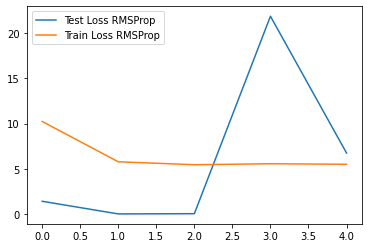

In [119]:
# Doing the SAME without pre trained weights and using different optimizers
plt.plot(val_losses,label="Test Loss RMSProp")
plt.plot(train_losses,label="Train Loss RMSProp")
plt.legend()

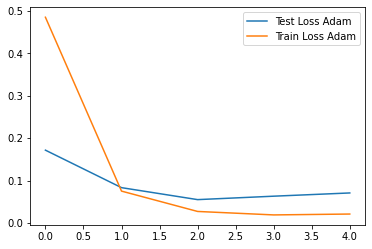

In [121]:
# Doing the SAME without pre trained weights and using different optimizers
plt.plot(val_losses,label="Test Loss Adam")
plt.plot(train_losses,label="Train Loss Adam")
plt.legend()